In [15]:
%pip install torch torchvision pillow matplotlib numpy


import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

Note: you may need to restart the kernel to use updated packages.


Model Training Metrics:
------------------------------
Epoch: 10
Training Loss: 1.0195928968029258
Validation Loss: 1.1524116195423502
Training IoU: 0.5391698094797723
Validation IoU: 0.4546867722356823


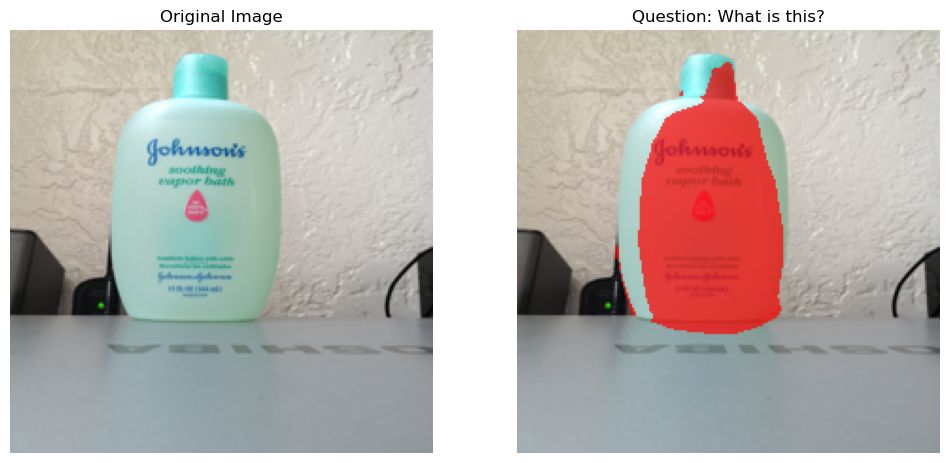

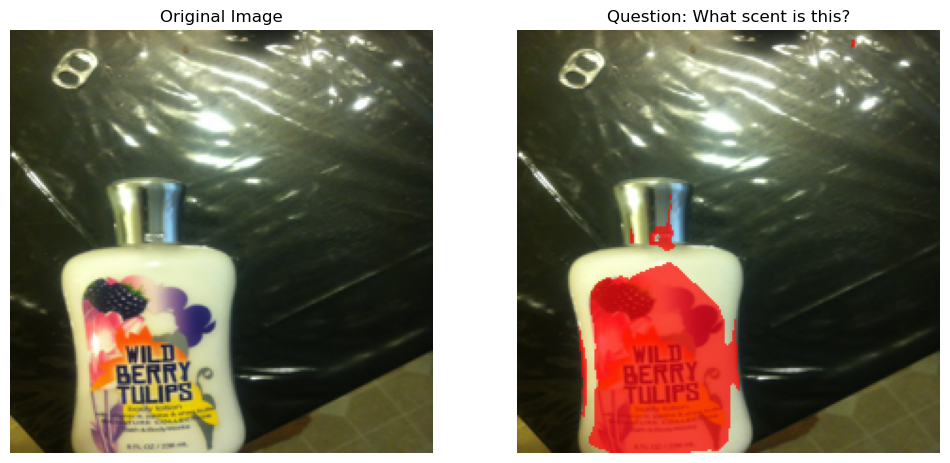

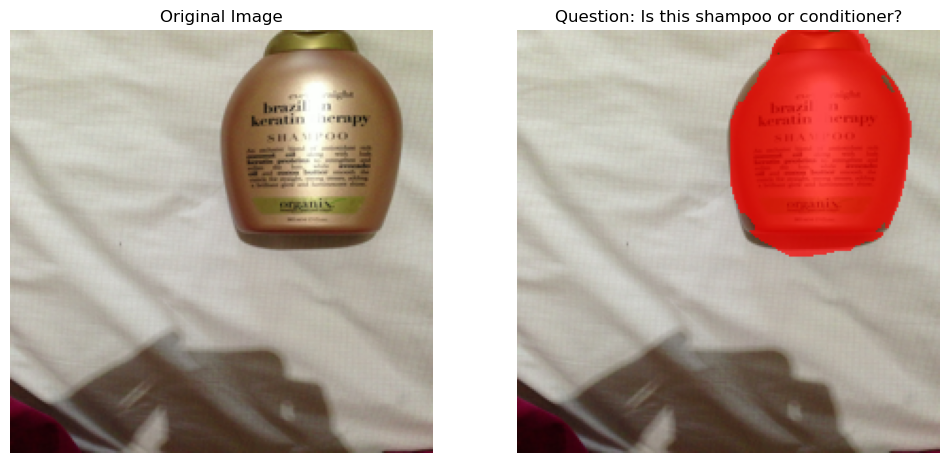

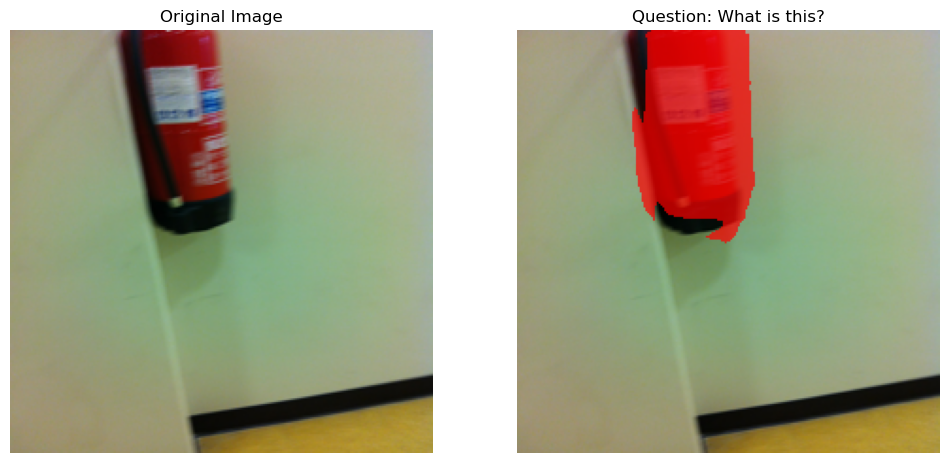

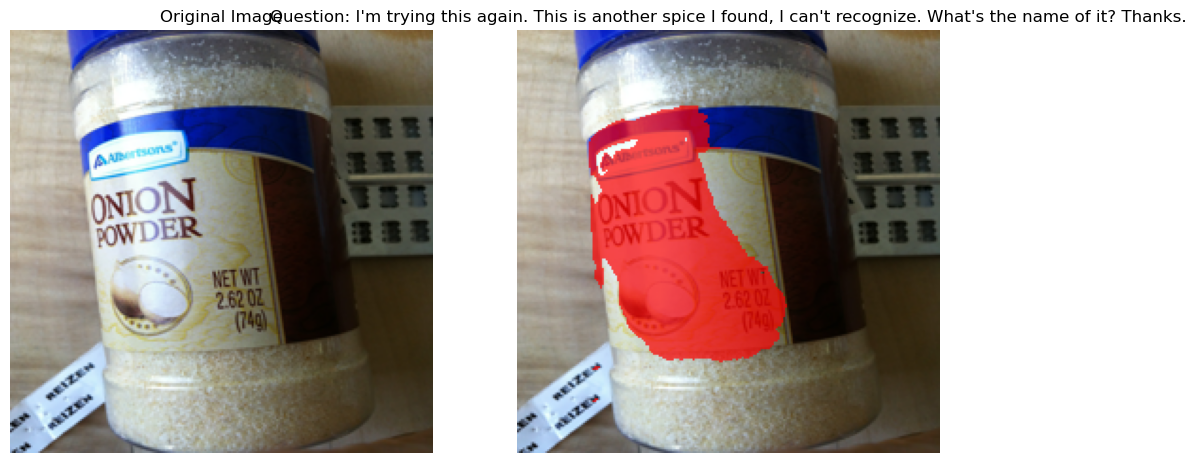

In [21]:


from model import AdvancedAnswerGroundingModel
MODEL_PATH = 'trained_model/best_advanced_model.pth'
DATA_DIR = 'data'
TEST_IMAGES_DIR = 'data/test'
TEST_QUESTIONS_PATH = 'data/test_grounding.json'


def load_test_examples():
    with open(TEST_QUESTIONS_PATH, 'r') as f:
        questions = json.load(f)
    
    test_examples = [
        {
            "image": os.path.join(TEST_IMAGES_DIR, image_name),
            "question": question_data['question']  
        }
        for image_name, question_data in questions.items()
    ]

    return test_examples

def preprocess_image(image_path):
    transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    image = Image.open(image_path).convert('RGB')

    return transform(image).unsqueeze(0) 

def visualize_mask(image_path, mask, question, save_path=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))
    image_np = np.array(image)
    mask_binary = (mask > 0.5).astype(np.float32)
    overlay = np.zeros_like(image_np, dtype=np.float32)
    overlay[:, :, 0] = mask_binary * 0.7  
    blended = image_np * (1 - mask_binary[:, :, np.newaxis] * 0.7) + overlay * 255
    blended = np.clip(blended, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title(f"Question: {question}")
    plt.axis('off')   
    plt.show()  
    plt.close()  


def get_model_metrics(model):
    print("Model Training Metrics:")
    print("-" * 30)
    print(f"Epoch: {model.get('epoch', 'N/A')}")
    print(f"Training Loss: {model.get('train_loss')}")
    print(f"Validation Loss: {model.get('val_loss')}")
    print(f"Training IoU: {model.get('train_iou')}")
    print(f"Validation IoU: {model.get('val_iou')}")


device=torch.device("cpu")
trained_model = torch.load(MODEL_PATH, map_location=device)
get_model_metrics(trained_model)

orig_model = AdvancedAnswerGroundingModel(
    pretrained=True,
    freeze_backbone=True,
    hidden_size=768,
    num_answers=1000,
    model_name="resnet"
)

orig_model.load_state_dict(trained_model['model_state_dict'])
orig_model = orig_model.to(device)
orig_model.eval()

test_examples = load_test_examples()

for example in test_examples[:5]:
    image_path = example['image']
    question = example['question']
    
    image_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        outputs = orig_model(image_tensor, [question])
        mask_probs = outputs["mask_probs"]
        mask = mask_probs[0, 0].cpu().numpy()
    
    visualize_mask(image_path, mask, question)







